# Classification Analysis

In [41]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from xgboost import XGBClassifier

def fb_score(y_true, y_pred, beta):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return ((1 + beta**2) * precision * recall) / ((beta**2) * precision + recall)

def f1_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall)

def f2_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (5 * precision * recall) / (4 * precision + recall)

def classification_results(y_true, y_pred, verbose=0):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_func(y_true, y_pred)
    f2 = f2_func(y_true, y_pred)
    if verbose:
        results = [
            ("accuracy", accuracy), 
            ("precision", precision),
            ("recall", recall),
            ("f1", f1),
            ("f2", f2),
        ]
        for (metric, score) in results:
            print(f"{metric} = {score:.2f}")
        print("\n")
    else:
        results = np.array([accuracy, precision, recall, f1, f2])
    return results

f1_score = make_scorer(f1_func)
f2_score = make_scorer(f2_func)

base_dir = os.path.join(os.getcwd(), os.pardir)

## Feature sets

Because a lot of the features in the dataset are highly correlated with eachother it makes sense to create some feature-sets so we can make analysis with or without certain groups of features.

As we are looking to see if increased screen time leads to poorer mental health, it does not make sense to make clasifications of `has_dep_diag` from all the features as this includes features such as `dep_score`, `dep_band`, `dep_thoughts` etc. which will contribute to the classification far more than screen time related features such as `comp_house` and `comp_games`.

We shall create feature sets for:

- __all__ features
- __non-medical__ features (depression, anxiety etc.)
- __only screen time__ features

In [2]:
target_feature = ["has_dep_diag"]
drop_features = ["prim_diag", "secd_diag"]

medical_features = [
    "mat_dep","mat_anx_1", "mat_anx_18m", 
    "mat_anx_8m", "agg_score", "emot_cruel", 
    "phys_cruel", "mat_anx_0m", "dep_band_15", 
    "dep_band_13", "dep_band_10", "dep_band_07", 
    "anx_band_15", "anx_band_13", "anx_band_10", 
    "anx_band_07", "secd_diag","prim_diag", 
    "panic_score", "dep_thoughts", "dep_score", 
]

# [feature for feature in all_features if not feature in medical_features]
non_medical_features = [
    "comp_bed_9", "mat_age", "weight_16", "height_16", "iq",
    "comp_noint_bed_16", "comp_int_bed_16", "talk_phon_wend", 
    "text_wend", "talk_mob_wend", "comp_wend", "musi_wend", 
    "read_wend", "work_wend", "alon_wend", "draw_wend", 
    "play_wend", "tv_wend", "out_win_wend", "out_sum_wend", 
    "tran_wend", "talk_phon_week", "text_week", "talk_mob_week", 
    "comp_week", "musi_week", "read_week", "work_week", 
    "alon_week", "draw_week", "play_week", "tv_week", 
    "out_win_week", "out_sum_week", "tran_week", "pat_pres_10",
    "pat_pres_8", "pat_pres", "num_home", "pat_ses", "mat_ses", 
    "pat_edu", "mat_edu", "parity", "exercise", "child_bull", 
    "phone_14_wend", "phone_14_week", "musi_13", "tv_bed_9", 
    "own_mob", "comp_house", "tv_bed_16", "creat_14", "comp_games", 
    "fam_tv_eve", "fam_tv_aft", "fam_tv_mor", "sex", "birth_order"
]

screen_time_features = [
    "comp_bed_9", "comp_noint_bed_16", 
    "comp_int_bed_16", "comp_wend", "tv_wend",
    "comp_week", "tv_week", "tv_bed_9", 
    "comp_house", "tv_bed_16", "comp_games", 
    "fam_tv_eve", "fam_tv_aft", "fam_tv_mor",
]

`note: we consider 'screen time' to be features relating to either a computer or TV.`

We can now create the reduced training and testing sets.

In [3]:
train_path = os.path.join(base_dir, "data/classification/train.csv")
test_path = os.path.join(base_dir, "data/classification/test.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

X_train, X_test = train_df.copy().drop(target_feature, axis=1), test_df.copy().drop(target_feature, axis=1)
y_train, y_test = train_df[target_feature], test_df[target_feature]

X_train_all = X_train.copy().drop(drop_features, axis=1)
X_test_all = X_test.copy().drop(drop_features, axis=1)

X_train_non_medical = X_train.copy()[non_medical_features]
X_test_non_medical = X_test.copy()[non_medical_features]

X_train_screen_time = X_train.copy()[screen_time_features]
X_test_screen_time = X_test.copy()[screen_time_features]

fsets = [
    ("all features", X_train_all, X_test_all),
    ("non medical features", X_train_non_medical, X_test_non_medical),
    ("screen time features", X_train_screen_time, X_test_screen_time),
]

## Class balance

We wish to perform classification on the feature `has_dep_diag`. Our evaluation metric of choice will depend on the balance of positive and negative samples. Let's look at the count of each.

minority:majority = 310:10677 (1:34)


<AxesSubplot:xlabel='class', ylabel='count'>

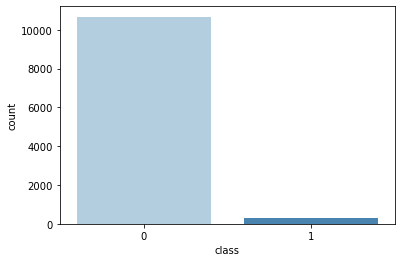

In [4]:
dep_counts = y_train.value_counts()
dep_list = list(zip([0, 1], dep_counts.tolist()))
sample_ratio = dep_counts[0] / dep_counts[1]
print(f"minority:majority = {dep_counts[1]}:{dep_counts[0]} (1:{sample_ratio:.0f})")

dep_df = pd.DataFrame(dep_list, columns=["class", "count"])
sns.barplot(x="class", y="count", data=dep_df, palette="Blues")

As you can see the distribution of values in this feature is massively uneven.

This is not ideal from a classification perspective, but we wouldn't really want half of the children in the study to be depressed!

This ratio as this be useful later; we call the positive class (1) the minority class and the negative class (0) the majority class.

## Metrics for imbalanced classification

When analysing the performance of classification on the imputated data we used F1-score as our target metric. We did so as we suspected we would have imbalanced classes and so standard accuracy would not perform well. F1-score is the harmonic mean of precision and recall, so maximising the F1-score results in a classifier sensitive to both true positives and false negatives.

F1-score is an instance of the more general metric F-score, or Fβ. The equation for Fβ is as follows:

```
Fβ = ((1 + β^2) * precision * recall) / ((β**2) * precision + recall)
```

With F1 we have:

```
F1 = ((1 + 1) * precision * recall) / (1 * precision + recall)
F1 = (2 * precision * recall) / precision + recall)
```

It then follows that the F2 score would be: 

```
F2 = (1 + 4) * precision * recall) / ((4) * precision + recall)
F2 = (5 * precision * recall) / (4 * precision + recall)
```

This results in a metric which weights recall higher than precision. What this means is we have a metric that is sensitive to false negatives.

False negative sensitivity is of particular interest to us as we would rather air on the side of caution and mis-classify someone as having depression and them receive treatment than classify someone who didn't as being ok. For this reason we shall use the F2 score as our target metric for further classification analysis.

`metrics defined during import (at the top)`

## Classification on feature sets

We shall perform classification on each of the feature sets.

In [156]:
fset_results = []

for (fset, fset_X_train, fset_X_test) in fsets:
    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=sample_ratio,
        n_jobs=-1,
    )
    xgb.fit(fset_X_train, y_train)
    preds = xgb.predict(fset_X_test)
    results = classification_results(y_test, preds)
    fset_results.append((fset, xgb, results))

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encod

Classification results.

In [160]:
columns = ["Accuracy", "Precision", "Recall", "F1-Score", "F2-Score"]
idxs = ["All", "Non-Medical", "Screen Time"]
default_df = pd.DataFrame([[x for x in xs] for xs in np.array(fset_results)[:,2]], columns=columns, index=idxs)
default_df

,Accuracy,Precision,Recall,F1-Score,F2-Score
All,0.992248,0.945946,0.958904,0.952381,0.956284
Non-Medical,0.960133,0.893617,0.575342,0.700000,0.619469
Screen Time,0.850498,0.308642,0.684932,0.425532,0.550661


## Classification optimisation

We can optimise these results with a grid search.

Let's specify the search parameters.

In [103]:
params = {
	"n_estimators": [100, 200],
	"max_depth": [5, 10],
# 	"gamma": [0, 0.5, 1],
	"min_child_weight": [1, 2],
	"subsample": [0.8, 1],
# 	"colsample_bytree": [0.9, 1],
}

Now we can run the parameter search for each of the 3 feature sets. We optimise for each feature set individually as due to the different sets of features, the models are effectively solving different problems. We shall use 3-fold cross-validation to optimise for F2-score.

In [104]:
gsearch_results = []

for (fset, fset_X_train, fset_X_test) in fsets:
    print(f"\nOptimising for {fset}...")
    gsearch = GridSearchCV(
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            scale_pos_weight=sample_ratio,
            n_jobs=-1,
        ),
        params, 
        scoring=f1_score, 
        cv=3, 
        verbose=3,
        n_jobs=1,
    )
    gsearch.fit(fset_X_train, y_train.to_numpy().ravel())
    gsearch_results.append((fset, gsearch))


Optimising for all features...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.698 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.708 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.685 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=1;, score=0.707 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=1;, score=0.676 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=1;, score=0.691 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.702 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.715 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.714 total time=   0.7s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=1;, score=0.696 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=1;, score=0.679 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=1;, score=0.697 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.707 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.715 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.667 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=1;, score=0.708 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=1;, score=0.655 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=1;, score=0.682 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.679 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.703 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.679 total time=   0.7s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=1;, score=0.709 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=1;, score=0.670 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=1;, score=0.688 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.676 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.735 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.694 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=1;, score=0.691 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=1;, score=0.703 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=1;, score=0.654 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.654 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.729 total time=   0.7s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.710 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=1;, score=0.691 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=1;, score=0.710 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=1;, score=0.660 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.690 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.714 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.710 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=1;, score=0.703 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=1;, score=0.702 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=1;, score=0.720 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.691 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.726 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.701 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=1;, score=0.682 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=1;, score=0.721 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=1;, score=0.729 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Optimising for non medical features...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.041 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.042 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.064 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=1;, score=0.037 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=1;, score=0.091 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=1;, score=0.059 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-41-2a3d0d177f91>:19: RuntimeWarning: invalid value encountered in double_scalars
  return (2 * precision * recall) / (precision + recall)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 

[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8;, score=nan total time=   0.6s
[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.032 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.063 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=1;, score=0.032 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=1;, score=0.048 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=1;, score=0.062 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.013 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.074 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.083 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=1;, score=0.025 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=1;, score=0.060 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=1;, score=0.066 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-41-2a3d0d177f91>:19: RuntimeWarning: invalid value encountered in double_scalars
  return (2 * precision * recall) / (precision + recall)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 

[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=0.8;, score=nan total time=   0.6s
[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.058 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.058 total time=   0.7s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-41-2a3d0d177f91>:19: RuntimeWarning: invalid value encountered in double_scalars
  return (2 * precision * recall) / (precision + recall)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 

[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=1;, score=nan total time=   0.5s
[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=1;, score=0.048 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=1;, score=0.057 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-41-2a3d0d177f91>:19: RuntimeWarning: invalid value encountered in double_scalars
  return (2 * precision * recall) / (precision + recall)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 

[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.8;, score=nan total time=   0.5s
[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.017 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.034 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-41-2a3d0d177f91>:19: RuntimeWarning: invalid value encountered in double_scalars
  return (2 * precision * recall) / (precision + recall)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 

[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=1;, score=nan total time=   0.6s
[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=1;, score=0.035 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=1;, score=0.070 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-41-2a3d0d177f91>:19: RuntimeWarning: invalid value encountered in double_scalars
  return (2 * precision * recall) / (precision + recall)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 

[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.8;, score=nan total time=   0.9s
[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.034 total time=   0.9s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.034 total time=   0.9s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-41-2a3d0d177f91>:19: RuntimeWarning: invalid value encountered in double_scalars
  return (2 * precision * recall) / (precision + recall)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 

[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=1;, score=nan total time=   1.3s
[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=1;, score=0.053 total time=   1.0s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=1;, score=0.071 total time=   0.9s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-41-2a3d0d177f91>:19: RuntimeWarning: invalid value encountered in double_scalars
  return (2 * precision * recall) / (precision + recall)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 

[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8;, score=nan total time=   0.5s
[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.051 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.060 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-41-2a3d0d177f91>:19: RuntimeWarning: invalid value encountered in double_scalars
  return (2 * precision * recall) / (precision + recall)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 

[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=1;, score=nan total time=   0.6s
[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=1;, score=0.067 total time=   0.7s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=1;, score=0.082 total time=   0.6s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.017 total time=   1.0s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.052 total time=   1.0s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.047 total time=   0.8s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-41-2a3d0d177f91>:19: RuntimeWarning: invalid value encountered in double_scalars
  return (2 * precision * recall) / (precision + recall)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 

[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=1;, score=nan total time=   0.8s
[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=1;, score=0.052 total time=   0.8s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=1;, score=0.065 total time=   0.8s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.04886185 0.06233323        nan 0.04730852 0.05694341 0.04999796
        nan        nan        nan        nan        nan        nan
        nan        nan 0.03873654        nan]
  warnings.warn(
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Optimising for screen time features...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.054 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.044 total time=   0.2s
[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.070 total time=   0.1s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=1;, score=0.054 total time=   0.1s
[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=1;, score=0.038 total time=   0.1s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=100, subsample=1;, score=0.084 total time=   0.1s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.042 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.030 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.055 total time=   0.3s
[CV 1/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=1;, score=0.049 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=1;, score=0.034 total time=   0.2s
[CV 3/3] END max_depth=5, min_child_weight=1, n_estimators=200, subsample=1;, score=0.082 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.065 total time=   0.1s
[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.053 total time=   0.1s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.073 total time=   0.2s
[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=1;, score=0.053 total time=   0.1s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=1;, score=0.049 total time=   0.1s
[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=100, subsample=1;, score=0.075 total time=   0.1s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.048 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.038 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.064 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=1;, score=0.050 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=1;, score=0.046 total time=   0.2s
[CV 3/3] END max_depth=5, min_child_weight=2, n_estimators=200, subsample=1;, score=0.073 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.039 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.036 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.057 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=1;, score=0.038 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=1;, score=0.037 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=100, subsample=1;, score=0.061 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.031 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.035 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=0.8;, score=0.038 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=1;, score=0.034 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=1;, score=0.033 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=1, n_estimators=200, subsample=1;, score=0.054 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.038 total time=   0.3s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.036 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8;, score=0.054 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=1;, score=0.037 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=1;, score=0.033 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=100, subsample=1;, score=0.059 total time=   0.2s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.031 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.034 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=0.8;, score=0.046 total time=   0.5s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=1;, score=0.034 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=1;, score=0.037 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=200, subsample=1;, score=0.052 total time=   0.4s


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Now we can look at the best parameters.

In [106]:
opt_params = []
for ((fset, search), (_, _, fset_X_test)) in zip(gsearch_results, fsets):
    opt_params.append(search.best_params_)
    print(f"{fset} {search.best_params_}:\n")  

all features {'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 1}:

non medical features {'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}:

screen time features {'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}:



Test the optimised classifiers on the test set.

In [107]:
opt_results = []

for ((fset, fset_X_train, fset_X_test), params) in zip(fsets, opt_params):
    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=sample_ratio,
        n_jobs=-1,
        max_depth=params["max_depth"], 
        min_child_weight=params["min_child_weight"], 
        n_estimators=params["n_estimators"], 
        subsample=params["subsample"],
    )
    xgb.fit(fset_X_train, y_train.to_numpy().ravel())
    preds = xgb.predict(fset_X_test)
    results = classification_results(y_test.to_numpy().ravel(), preds)
    opt_results.append((fset, xgb, results))

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


After some additonal tweaking, optimal parameters were found as follows:

In [109]:
final_results = []

for (fset, fset_X_train, fset_X_test) in fsets:
    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=sample_ratio,
        n_jobs=-1,
        max_depth=10, 
        min_child_weight=1, 
        n_estimators=200, 
        subsample=1,
    )
    xgb.fit(fset_X_train, y_train.to_numpy().ravel())
    preds = xgb.predict(fset_X_test)
    results = classification_results(y_test.to_numpy().ravel(), preds)
    final_results.append((fset, xgb, results))

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/skle

`note: as parameters are similar to defaults and each model performed similarly with the same parameters we chose to keep all parameters the same between models`

In [166]:
columns = ["Accuracy", "Precision", "Recall", "F1-Score", "F2-Score"]
idxs = ["All", "Non-Medical", "Screen Time"]
optimised_df = pd.DataFrame([[x for x in xs] for xs in np.array(final_results)[:,2]], columns=columns, index=idxs)
optimised_df

,Accuracy,Precision,Recall,F1-Score,F2-Score
All,0.994463,0.972222,0.958904,0.965517,0.961538
Non-Medical,0.974529,0.962963,0.712329,0.818898,0.751445
Screen Time,0.906977,0.452174,0.712329,0.553191,0.638821


Lets compare this to the previous metrics. We shall calculate the percentage change of each metric after optimsation.

In [172]:
increase_df = 100 * (optimised_df / default_df) - 100
increase_df

,Accuracy,Precision,Recall,F1-Score,F2-Score
All,0.223214,2.777778,0.000000,1.379310,0.549451
Non-Medical,1.499423,7.760141,23.809524,16.985377,21.304707
Screen Time,6.640625,46.504348,4.000000,30.000000,16.009828


<AxesSubplot:title={'center':'Classification Metrics of Depression Diagnosis Using Imputed Datasets'}>

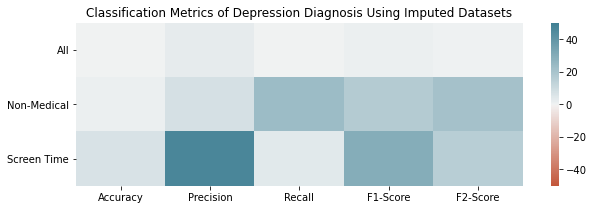

In [203]:
plt.figure(figsize=(10,3))
plt.title("Classification Metrics of Depression Diagnosis Using Imputed Datasets")
sns.heatmap(increase_df, cmap=sns.diverging_palette(20, 220, as_cmap=True), vmin=-50, vmax=50)

We see increases in metrics across the board. Performance seemed to increase more when classifying with a smaller feature set. This is to be expected the lower the performace, the greater the relative increase. 

## Feature Importances

Now we have optimal classifiers, we can look at feature iportances of each feature set.

In [111]:
cols = ["Feature", "Importance", "Feature Set"]
importance_df = pd.DataFrame(columns=cols)
fset_cols = [fset[1].columns for fset in fsets]

for (features, (fset, fset_xgb, fset_result)) in zip(fset_cols, final_results):
    imps = fset_xgb.feature_importances_
    for (feature, imp) in zip(features, imps):
        importance_df = importance_df.append(pd.DataFrame([[feature, imp, fset]], columns=cols))

importance_df

,Feature,Importance,Feature Set
0,comp_bed_9,0.005073,all features
0,mat_dep,0.004276,all features
0,mat_age,0.003674,all features
0,weight_16,0.004008,all features
0,height_16,0.005638,all features
...,...,...,...
0,tv_bed_16,0.093968,screen time features
0,comp_games,0.043491,screen time features
0,fam_tv_eve,0.052400,screen time features
0,fam_tv_aft,0.057008,screen time features


All features importance.

<AxesSubplot:title={'center':'Feature Importance for Prediction of Depression Diagnosis from All non-Diagnosis Features'}, xlabel='Feature', ylabel='Importance'>

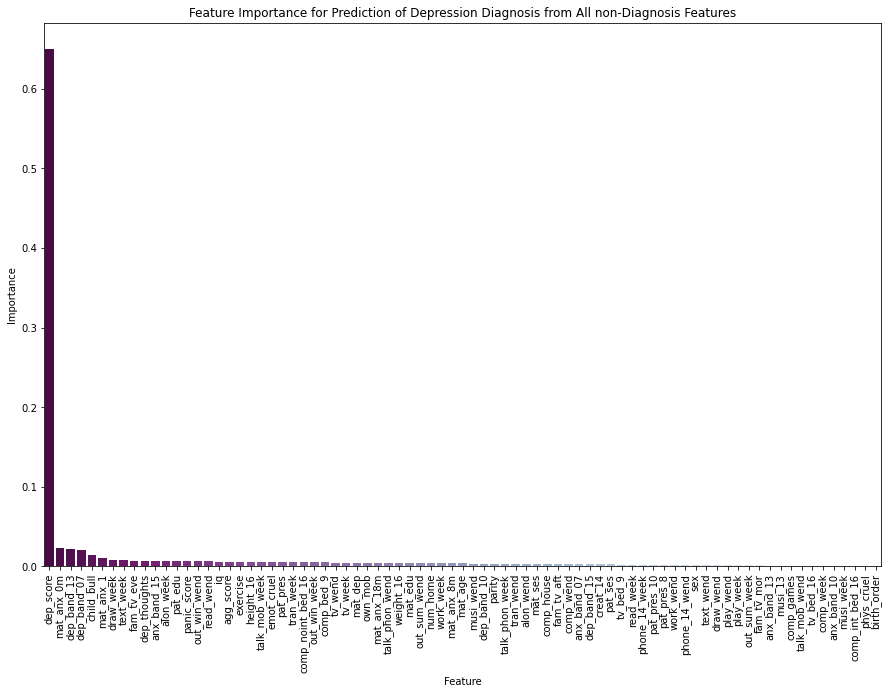

In [112]:
all_imp_df = importance_df[importance_df["Feature Set"] == "all features"]

fig = plt.figure(figsize=(15,10))
plt.title("Feature Importance for Prediction of Depression Diagnosis from All non-Diagnosis Features")
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=all_imp_df.sort_values("Importance", ascending=False), palette="BuPu_r")

As we can see above the target feature `has_dep_diag` is almost exclusively represented by medical features, in particular `dep_score`, which is a medical metric for depression severity. This makes sense as having a depression score of over 0 would suggest they have a depression diagnosis.

Lets look at the feature importances when we remove medical features to get a better understanding of the dataset.

<AxesSubplot:title={'center':'Feature Importance for Prediction of Depression Diagnosis from Non-Medical Features'}, xlabel='Feature', ylabel='Importance'>

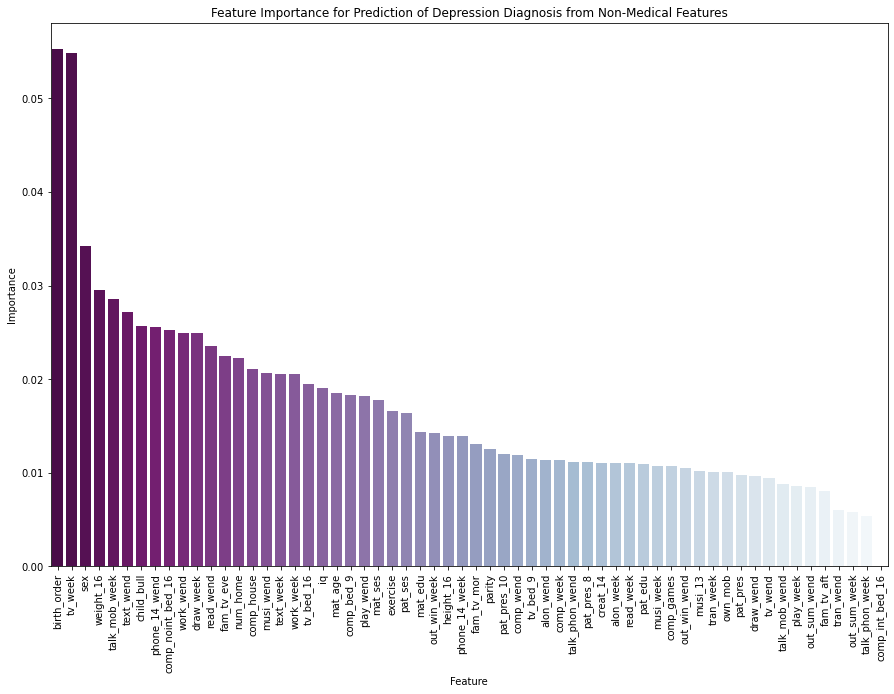

In [113]:
nonmed_imp_df = importance_df[importance_df["Feature Set"] == "non medical features"]

fig = plt.figure(figsize=(15,10))
plt.title("Feature Importance for Prediction of Depression Diagnosis from Non-Medical Features")
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=nonmed_imp_df.sort_values("Importance", ascending=False), palette="BuPu_r")

Now for only screen time features.

<AxesSubplot:title={'center':'Feature Importance for Prediction of Depression Diagnosis from Screen Time Features'}, xlabel='Feature', ylabel='Importance'>

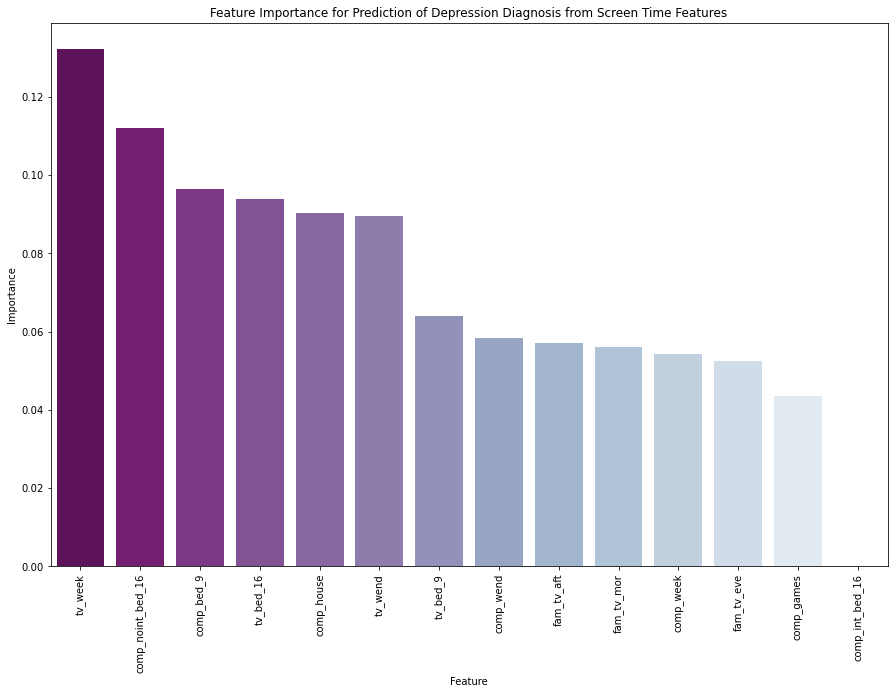

In [114]:
screentime_imp_df = importance_df[importance_df["Feature Set"] == "screen time features"]

fig = plt.figure(figsize=(15,10))
plt.title("Feature Importance for Prediction of Depression Diagnosis from Screen Time Features")
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=screentime_imp_df.sort_values("Importance", ascending=False), palette="BuPu_r")

## Final classification results

In [155]:
results_df = pd.DataFrame(
    np.asarray([np.append(results[0], results[2]) for results in final_results]),
    columns=["Imputation Method", "Accuracy", "Precision", "Recall", "F1-Score", "F2-Score"]
)

results_df.set_index("Imputation Method", inplace=True)
results_df = results_df.astype(float)
results_df

,Accuracy,Precision,Recall,F1-Score,F2-Score
Imputation Method,,,,,
all features,0.994463,0.972222,0.958904,0.965517,0.961538
non medical features,0.974529,0.962963,0.712329,0.818898,0.751445
screen time features,0.906977,0.452174,0.712329,0.553191,0.638821


<AxesSubplot:title={'center':'Classification Metrics of Depression Diagnosis Using Imputed Datasets'}, ylabel='Imputation Method'>

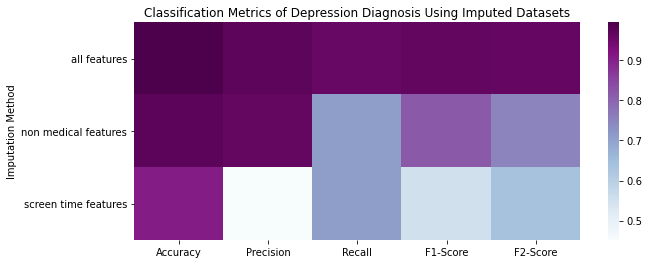

In [180]:
plt.figure(figsize=(10,4))
plt.title("Classification Metrics of Depression Diagnosis Using Imputed Datasets")
sns.heatmap(results_df, cmap="BuPu")